## Gym membersexercise tracking

Набор данных содержит подробную информацию о тренировочных режимах, физических характеристиках и фитнес-метриках членов тренажерного зала. В нем представлено 973 записи, каждая из которых включает 15 переменных, таких как возраст, пол, вес, рост, максимальная и средняя частота сердечных сокращений, количество часов тренировок, сожженные калории, тип тренировки, процент жира, содержание воды в организме, количество тренировочных дней в неделю, уровень подготовки и индекс массы тела (BMI).

In [1]:
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dataset_name = "gym_members_exercise_tracking.csv"
path = kagglehub.dataset_download("valakhorasani/gym-members-exercise-dataset") + "/" + dataset_name
df = pd.read_csv(path)
df.head(100)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,59,Female,54.6,1.57,164,169,64,0.58,441.0,Cardio,29.2,2.3,3,1,22.15
96,56,Male,129.0,1.78,194,126,64,1.29,805.0,Yoga,27.1,2.7,2,1,40.71
97,58,Male,103.5,1.66,172,168,61,1.33,1106.0,Cardio,24.6,3.1,3,1,37.56
98,45,Female,59.4,1.51,169,142,65,1.15,735.0,Strength,33.1,1.9,4,2,26.05


In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

In [3]:
df.shape

(973, 15)

# Берем в роли целевого класса метку Workout_Type

Для обоснования выбора именно такого целевого класса можно сказать, что при таком выборе, данный датасет можно использовать для определения типа тренировок по определенным параметрам, такие параметры можно собирать, используя ,например, датчики на смарт часах.

In [4]:

# df.head(100)

## Проверим пустые значения

In [5]:
df.isnull().sum()

Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64

Пустых значений не обнаружено

## Уберем выбросы

In [6]:
for column in df.columns:
    if column == "Workout_Type":
        continue
    first_quantile = df[column].quantile(0.25)
    third_quantile = df[column].quantile(0.75)
    iqr = (third_quantile - first_quantile)
    delta = iqr * 1.5
    lower_threshold = first_quantile - delta
    upper_threshold = third_quantile + delta
    df = df[(df[column] >= lower_threshold) & (df[column] <= upper_threshold)]

In [7]:
x = df.drop('Workout_Type', axis=1)
mapping = {'Strength': 1, 'Cardio': 2, 'Yoga': 3, 'HIIT': 4}
y = df['Workout_Type'].map(mapping)
x.shape, y.shape

((931, 14), (931,))

In [8]:
counts = y.value_counts()
counts

Workout_Type
1    245
2    245
3    231
4    210
Name: count, dtype: int64

In [9]:
counts = list(counts)

In [10]:
for count in counts:
    print(count / sum(counts))

0.2631578947368421
0.2631578947368421
0.24812030075187969
0.22556390977443608


# Вывод о сбалансировании классов

Так как количество элементов разных классов примерно одинакого и нет отдельно доминирующих классов, то можно считать данные сбалансированными

Делим выборку на тестовую и обучающую

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=17)

In [13]:
X_train.shape, X_test.shape

((744, 14), (187, 14))

# Используем методы классификации

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Используем grid search для нахождения гиперпараметров

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
params = {"max_depth": list(range(1, 100)), "max_features": [0.5, 0.7, 1]}
tree = DecisionTreeClassifier(random_state=17)

In [17]:
grid = GridSearchCV(tree, params, cv=5, n_jobs=-1)

In [18]:
%%time
grid.fit(X_train, Y_train)

CPU times: user 833 ms, sys: 270 ms, total: 1.1 s
Wall time: 3.91 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [0.5, 0.7, 1]})

In [19]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=19, max_features=1, random_state=17)

In [20]:
grid.best_score_

np.float64(0.2876201705060765)

In [21]:
grid.best_params_

{'max_depth': 19, 'max_features': 1}

## Используем KNN

Перед применением knn нужно обработать значения

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(X_train)
for_test = scaler.fit_transform(X_test)
knn_test = pd.DataFrame(for_test, columns=X_test.columns)
knn_df = pd.DataFrame(standardized_data, columns=X_train.columns)

In [23]:
knn_params = {'n_neighbors': list(range(1, 200)), 'metric': ['euclidean', 'manhattan', 'chebyshev']}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=5, n_jobs=-1)


In [24]:
%%time
knn_grid.fit(knn_df, Y_train)

CPU times: user 1.29 s, sys: 80.7 ms, total: 1.38 s
Wall time: 8.44 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [25]:
knn_grid.best_score_

np.float64(0.3078904407763468)

In [26]:
knn_grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 70}

In [27]:
from sklearn.metrics import accuracy_score

# Посчитаем accuracy

In [28]:
tree_test = grid.predict(X_test)

In [29]:
knn_test_pred = knn_grid.predict(knn_test)

In [30]:
accuracy_score(Y_test, tree_test) # accuracy для дерева

0.27807486631016043

In [31]:
accuracy_score(Y_test, knn_test_pred) # accuracy для knn

0.22459893048128343

# Сравним параметры accuracy, precision, recall и F-score для двух классификаторов

In [32]:
tree_test

array([1, 1, 1, 2, 1, 4, 3, 1, 4, 3, 3, 4, 3, 4, 1, 2, 1, 2, 3, 1, 1, 3,
       1, 4, 2, 2, 1, 3, 4, 4, 3, 4, 4, 4, 1, 2, 2, 3, 4, 3, 1, 4, 2, 1,
       1, 2, 1, 4, 1, 4, 2, 2, 2, 4, 1, 2, 4, 3, 1, 4, 2, 3, 4, 3, 3, 2,
       4, 2, 2, 3, 4, 2, 2, 4, 2, 4, 2, 3, 3, 2, 3, 1, 4, 2, 3, 3, 2, 4,
       1, 1, 2, 3, 2, 2, 2, 4, 2, 1, 4, 1, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 4, 2, 1, 3, 1, 2, 1, 3, 2, 2, 4, 4, 3, 3, 3, 2, 2, 1, 2,
       3, 2, 4, 1, 2, 4, 2, 2, 1, 1, 4, 2, 2, 1, 3, 1, 2, 2, 2, 1, 4, 4,
       1, 1, 1, 3, 2, 2, 4, 4, 1, 3, 4, 1, 1, 2, 1, 1, 3, 4, 3, 3, 2, 3,
       1, 4, 4, 4, 3, 3, 1, 2, 1, 4, 1])

In [33]:
knn_test_pred

array([1, 1, 1, 1, 1, 2, 1, 1, 4, 2, 2, 4, 3, 1, 1, 2, 1, 4, 2, 4, 1, 1,
       2, 3, 2, 2, 1, 3, 2, 3, 2, 1, 4, 4, 2, 3, 4, 1, 3, 3, 1, 1, 3, 1,
       3, 3, 2, 4, 1, 3, 2, 1, 4, 3, 3, 1, 1, 1, 1, 4, 4, 3, 1, 3, 3, 2,
       3, 2, 2, 3, 3, 4, 3, 1, 2, 2, 3, 3, 1, 1, 2, 3, 1, 1, 3, 1, 2, 2,
       1, 2, 4, 1, 2, 4, 1, 2, 2, 2, 3, 1, 2, 2, 2, 3, 3, 1, 2, 1, 2, 1,
       1, 3, 2, 4, 1, 2, 1, 2, 3, 4, 2, 1, 3, 1, 2, 3, 3, 1, 3, 2, 2, 4,
       1, 1, 1, 3, 3, 2, 1, 3, 4, 3, 4, 3, 2, 2, 1, 1, 4, 2, 2, 3, 3, 3,
       2, 3, 2, 2, 4, 1, 4, 1, 1, 1, 1, 4, 2, 4, 1, 3, 4, 2, 2, 3, 3, 2,
       1, 3, 3, 2, 4, 2, 3, 3, 2, 1, 3])

In [34]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(Y_test, knn_test_pred))

              precision    recall  f1-score   support

           1       0.21      0.23      0.22        52
           2       0.28      0.29      0.29        52
           3       0.24      0.29      0.26        42
           4       0.12      0.07      0.09        41

    accuracy                           0.22       187
   macro avg       0.21      0.22      0.21       187
weighted avg       0.22      0.22      0.22       187



In [36]:
print(classification_report(Y_test, tree_test))

              precision    recall  f1-score   support

           1       0.30      0.27      0.28        52
           2       0.31      0.35      0.33        52
           3       0.16      0.14      0.15        42
           4       0.31      0.34      0.33        41

    accuracy                           0.28       187
   macro avg       0.27      0.27      0.27       187
weighted avg       0.27      0.28      0.28       187



# Вывод из анализа классификаторов

Как видно из вышепредставленных метрик, оба классификатора показывают невероятно плохой результат, что может быть связано с малым количеством самих данных. Так как в классах наблюдается баланс, то можно опираться на значения accuracy, которое больше для дерева, так же как и все остальные параметры, средний precision больше для дерева, recall - также больше для дерева, сравнение средне F меры по классам показывает, что дерево хуже работает для класса 3, в то время как у метода ближайших соседей проблемы с классом 4. Однако различия между результами очень малы и нельзя сказать, какой классификатор показывает более хороший результат. Возможно в случае с данным набором данные необходимо использование другого метода классификации, также такие результаты могут быть обусловлены выбранным целевым атрибутом.

# Анализ с использованием ROC кривой и AUC

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


Y_test_bin = label_binarize(Y_test, classes=[1, 2, 3, 4]) 


In [38]:
knn_test_probs = knn_grid.predict_proba(knn_test)
tree_test_probs = grid.predict_proba(X_test) 

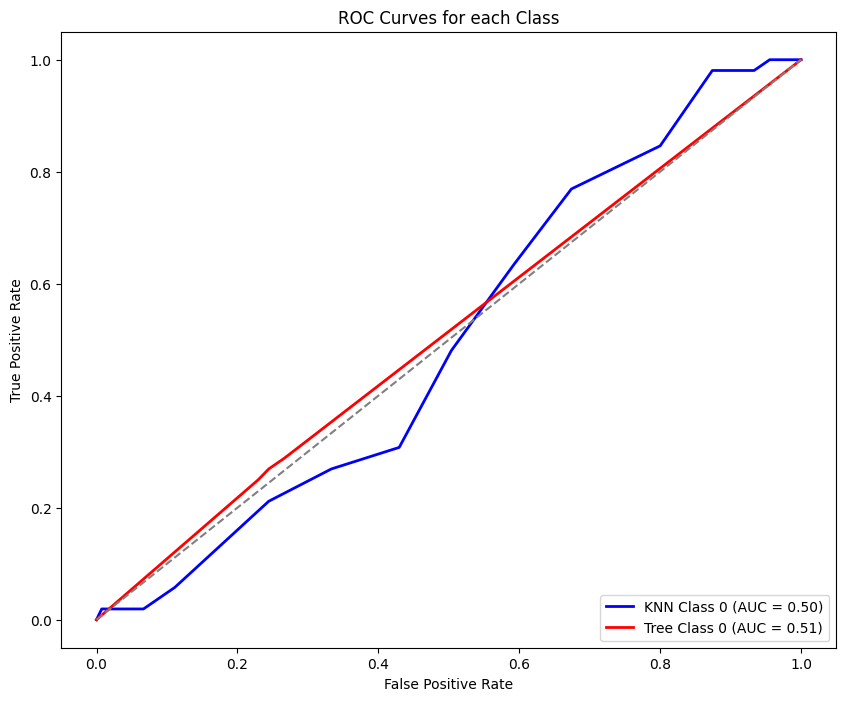

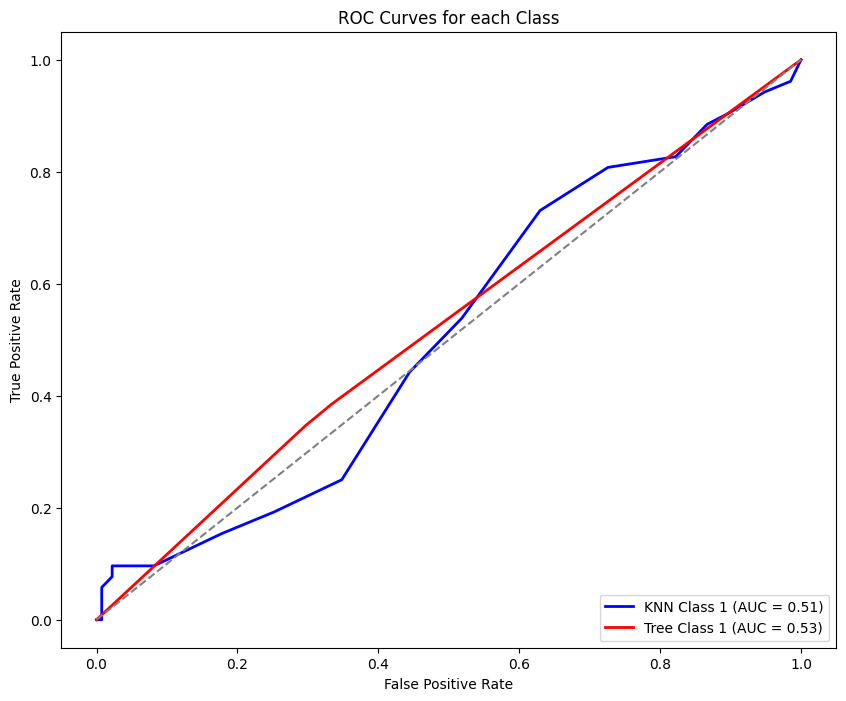

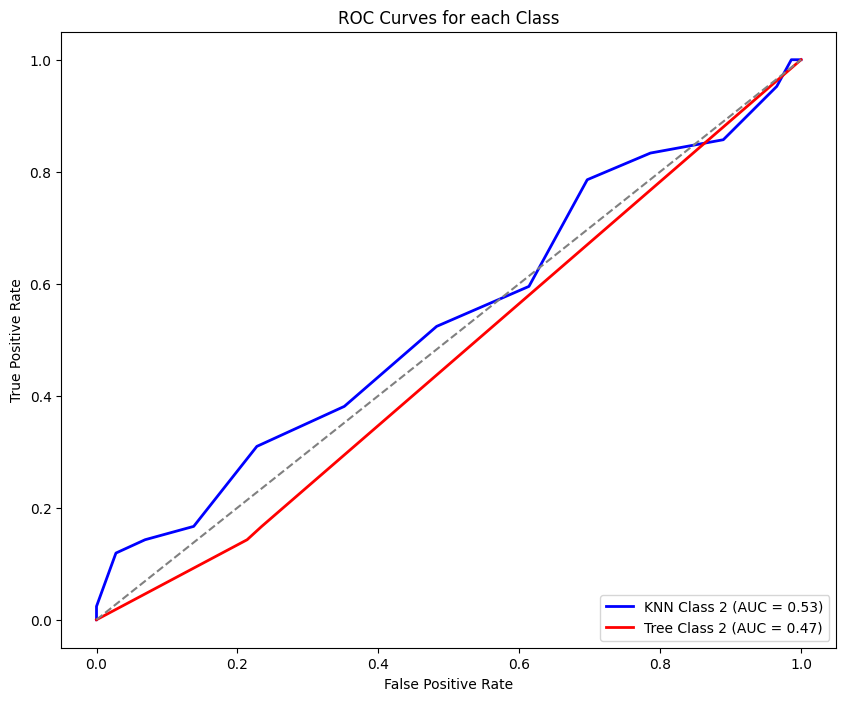

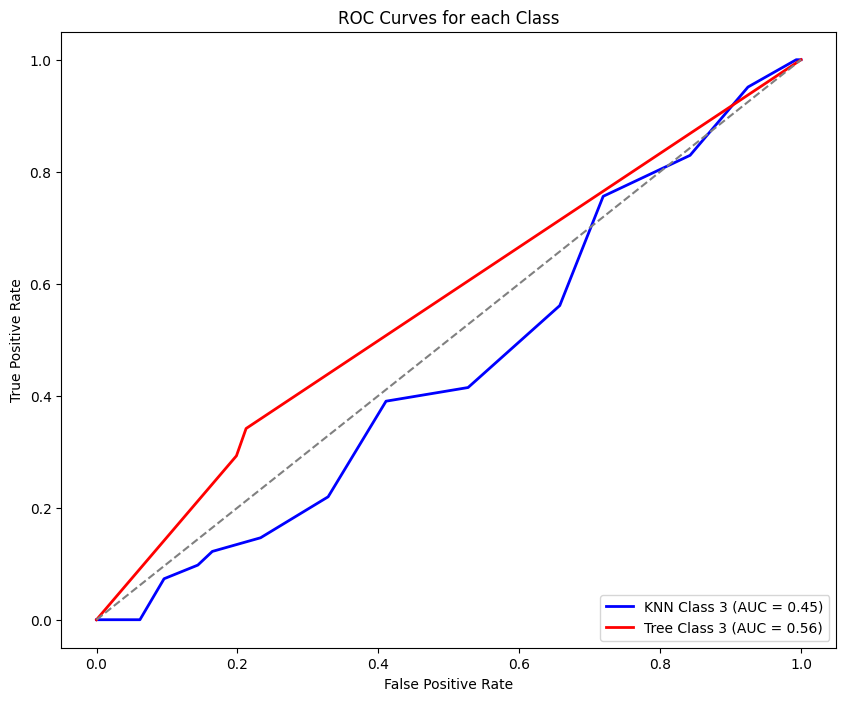

In [39]:


for i in range(4):
    plt.figure(figsize=(10, 8))
    fpr_knn, tpr_knn, _ = roc_curve(Y_test_bin[:, i], knn_test_probs[:, i])
    auc_knn = auc(fpr_knn, tpr_knn)
    
    fpr_tree, tpr_tree, _ = roc_curve(Y_test_bin[:, i], tree_test_probs[:, i])
    auc_tree = auc(fpr_tree, tpr_tree)
    
    plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN Class {i} (AUC = {auc_knn:.2f})')
    plt.plot(fpr_tree, tpr_tree, color='red', lw=2, label=f'Tree Class {i} (AUC = {auc_tree:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each Class')
    plt.legend(loc='lower right')
    plt.show()


# Анализ ROC кривых

Анализируя полученные результаты можно сделать вывод, что классификаторы недостаточно точные, а их результаты близки к случайному отгадыванию.

# Вывод

В ходе работы были изучены методы классификации: метод K ближайших соседей и дерево решений, в процессе работы были подобраны оптимальные гиперпараметры. Были рассмотренны оценки качества модели с использованием f-меры, ROC кривых и параметра AUC, был выбран целевой параметр и проведена оценка сбалансированности классов.